In [2]:
import os
import re
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import pandas as pd
import json
import scipy.sparse as sp
import scipy.sparse.linalg as spla
from scipy.sparse.linalg import svds
from scipy.sparse import csr_matrix, coo_matrix
from collections import defaultdict
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import from_networkx
from torch_geometric.nn import SAGEConv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

## 모델 구현

In [11]:
# 주변 노드 정보를 고려하여 신뢰 구간을 학습하는 GNN
# 고정된 분위수가 아닌 모델이 학습하면서 신뢰구간을 예측하도록 설계 -> 유연한 방식
class QuantileGNNLayer(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(QuantileGNNLayer, self).__init__()
        self.conv = SAGEConv(in_channels, hidden_channels)  # 그래프 메세지 패싱을 수행하는 레이어
        self.fc = nn.Linear(hidden_channels, out_channels)  # 최종 출력을 위한 선형 변환

    def forward(self, x, edge_index):
        h = self.conv(x, edge_index)  # GNN 메세지 패싱 수행
        h = F.relu(h)   # 활성화 함수 적용 (비선형 변환)
        h = self.fc(h)  # 최종 분위수 얘측
        return h  # (num_nodes, 2) 반환 (ql qu)

# 신뢰 구간을 예측하는 GNN 모델
class QuantileGNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=2):
        super(QuantileGNN, self).__init__()
        self.layer1 = QuantileGNNLayer(input_dim, hidden_dim, hidden_dim)
        self.layer2 = QuantileGNNLayer(hidden_dim, hidden_dim, output_dim)  # 최종 출력 2차원 (q1, q2)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.layer1(x, edge_index))
        x = self.layer2(x, edge_index)  # 최종 분위수 출력
        return x  # (num_nodes, 2) 반환

class DynamicRQRLoss(nn.Module):
    def __init__(self, target_coverage=0.9, lambda_factor=0.1):
        super(DynamicRQRLoss, self).__init__()
        self.target_coverage = target_coverage
        self.lambda_factor = lambda_factor

    def forward(self, preds, target):
        q1, q2 = preds[:, 0], preds[:, 1]
        width = q2 - q1

        # 기존 RQRW Loss (완화된 분위수 회귀)
        diff_mu_1 = target - q1
        diff_mu_2 = target - q2
        rqr_loss = torch.maximum(diff_mu_1 * diff_mu_2 * (self.target_coverage + 2 * self.lambda_factor),
                                 diff_mu_2 * diff_mu_1 * (self.target_coverage + 2 * self.lambda_factor - 1))

        # 신뢰구간 너비 최소화 정규화
        width_penalty = self.lambda_factor * torch.square(width) * 0.5
        
        # 분위수 교차 방지?

        return torch.mean(rqr_loss + width_penalty)

def train_quantile_gnn(graph_data, train_data, epochs=1000, learning_rate=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # 모델 초기화
    input_dim = graph_data.x.shape[1]
    model = QuantileGNN(input_dim=input_dim, hidden_dim=64).to(device)
    criterion = DynamicRQRLoss(target_coverage=0.9, lambda_factor=0.1)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_mask = torch.tensor([i in train_data for i in range(graph_data.x.shape[0])])
    
    graph_data = graph_data.to(device)

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        preds = model(graph_data)
        loss = criterion(preds[train_mask], graph_data.y[train_mask])
        loss.backward()
        optimizer.step() # 모델 업데이트

        if epoch % 100 == 0:
            print(f"Epoch {epoch}: Loss = {loss.item():.4f}")

    return model

def test_quantile_gnn(model, graph_data, test_data):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()  # 모델을 평가 모드로 설정

    test_mask = torch.tensor([i in test_data for i in range(graph_data.x.shape[0])])
    graph_data = graph_data.to(device)

    with torch.no_grad():  # 그래디언트 계산 없이 예측 수행
        test_preds = model(graph_data)[test_mask]  # (num_test_nodes, 2) → 분위수 예측값
        test_targets = graph_data.y[test_mask]  # 실제 정답

    return test_preds.cpu().numpy(), test_targets.cpu().numpy()

def evaluate_model_performance(test_preds, test_targets, coverage_target=0.9):
    ql = test_preds[:, 0]  # 신뢰구간 하한 (예측값)
    qu = test_preds[:, 1]  # 신뢰구간 상한 (예측값)
    
    coverage = np.mean((test_targets >= ql) & (test_targets <= qu))

    interval_width = np.mean(qu - ql)
    
    mae = np.mean(np.abs((ql + qu) / 2 - test_targets))  # 신뢰구간 중앙값과 실제 값 비교

    print(f"   - Coverage Rate: {coverage:.4f} (목표: {coverage_target})")
    print(f"   - Prediction Interval Width: {interval_width:.4f}")
    print(f"   - Mean Absolute Error (MAE): {mae:.4f}\n")

    # return coverage, interval_width, mae

def advanced_evaluate_model(test_preds, test_targets, coverage_target=0.9):
    """
    추가적인 평가 지표를 포함한 모델 평가 함수
    """
    q1 = test_preds[:, 0]  # 신뢰구간 하한
    q2 = test_preds[:, 1]  # 신뢰구간 상한
    median_pred = (q1 + q2) / 2  # 신뢰구간 중앙값

    coverage = np.mean((test_targets >= q1) & (test_targets <= q2))

    interval_width = np.mean(q2 - q1)

    mae = np.mean(np.abs(median_pred - test_targets))

    sharpness = np.mean(np.square(q2 - q1))

    alpha = 1 - coverage_target  # 신뢰구간 목표
    lower_penalty = np.maximum(q1 - test_targets, 0) * (alpha / 2)
    upper_penalty = np.maximum(test_targets - q2, 0) * (alpha / 2)
    interval_score = interval_width + 2 * (lower_penalty + upper_penalty).mean()

    def pinball_loss(y_true, y_pred, quantile):
        return np.maximum(quantile * (y_true - y_pred), (quantile - 1) * (y_true - y_pred)).mean()
    
    pinball_loss_lower = pinball_loss(test_targets, q1, alpha / 2)
    pinball_loss_upper = pinball_loss(test_targets, q2, 1 - alpha / 2)

    calibration_error = np.abs(coverage - coverage_target)

    print(f"   - Coverage Rate: {coverage:.4f} (목표: {coverage_target})")
    print(f"   - Prediction Interval Width (PIW): {interval_width:.4f}")
    print(f"   - Mean Absolute Error (MAE): {mae:.4f}")
    print(f"   - Sharpness: {sharpness:.4f} (작을수록 좋음)")
    print(f"   - Interval Score (IS): {interval_score:.4f} (작을수록 좋음)")
    print(f"   - Pinball Loss (Lower): {pinball_loss_lower:.4f}, (Upper): {pinball_loss_upper:.4f}")
    print(f"   - Calibration Error: {calibration_error:.4f} (0에 가까울수록 좋음)\n")

    return {
        "coverage": coverage,
        "interval_width": interval_width,
        "mae": mae,
        "sharpness": sharpness,
        "interval_score": interval_score,
        "pinball_loss_lower": pinball_loss_lower,
        "pinball_loss_upper": pinball_loss_upper,
        "calibration_error": calibration_error
    }

def visualize_results(preds, targets, title="Quantile GNN - Prediction Intervals"):
    lower_bound = preds[:, 0]  # 신뢰구간 하한
    upper_bound = preds[:, 1]  # 신뢰구간 상한

    plt.figure(figsize=(15, 5))
    plt.plot(targets, label="True Values", marker='o', alpha = 0.5)
    plt.fill_between(range(len(targets)), lower_bound, upper_bound, color='blue', alpha=0.3, label="Prediction Intervals(target coverage = 90%)")
    plt.legend()
    plt.xlabel("Node Index")
    plt.ylabel("Prediction")
    plt.title(title)
    plt.show()
    
def experiment_results_to_df(experiment_results):
    data = []
    for noise_type, results in experiment_results.items():
        train_metrics = results["train"]
        test_metrics = results["test"]
        
        data.append([
            noise_type.upper(),  
            train_metrics["coverage"], test_metrics["coverage"],  
            train_metrics["interval_width"], test_metrics["interval_width"],
            train_metrics["mae"], test_metrics["mae"],
            train_metrics["interval_score"], test_metrics["interval_score"],
        ])
    
    df = pd.DataFrame(data, columns=[
        "Noise Type",  
        "Train Coverage", "Test Coverage",  
        "Train Interval Width", "Test Interval Width",
        "Train MAE", "Test MAE",
        "Train Interval Score", "Test Interval Score"
    ])
    
    return df

def plot_experiment_results(experiment_df):
    noise_types = experiment_df["Noise Type"]
    
    metrics = [
        ("Train Coverage", "Test Coverage"),
        ("Train Interval Width", "Test Interval Width"),
        ("Train MAE", "Test MAE"),
        ("Train Interval Score", "Test Interval Score")
    ]
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    axes = axes.flatten()
    
    for i, (train_metric, test_metric) in enumerate(metrics):
        train_values = experiment_df[train_metric]
        test_values = experiment_df[test_metric]
        
        x = np.arange(len(noise_types))
        width = 0.35
        
        axes[i].bar(x - width/2, train_values, width, label="Train")
        axes[i].bar(x + width/2, test_values, width, label="Test")
        
        axes[i].set_xticks(x)
        axes[i].set_xticklabels(noise_types, rotation=45)
        axes[i].set_title(f"{train_metric} vs {test_metric}")
        axes[i].legend()
    
    plt.tight_layout()
    plt.show()

## 기본 그래프

In [15]:
def generate_graph_data(num_nodes = 1000):
    np.random.seed(1127)
    torch.manual_seed(1127)
    
    # 비선형 데이터
    X = np.random.rand(num_nodes, 5)  # 5차원
    y = np.sin(X[:, 0] * 3) + 0.1 * np.random.rand(num_nodes)
    
    # 임의 엣지 생성
    edge_index = torch.randint(0, num_nodes, (2, num_nodes * 2))
    
    # PyG 데이터 변환
    return Data(
        x = torch.tensor(X, dtype = torch.float32),
        edge_index= edge_index,
        y = torch.tensor(y, dtype = torch.float32).unsqueeze(1),
    )

def generate_noisy_graph_data(num_nodes=1000, noise_type="gaussian", noise_level=0.1, outlier_ratio=0.05):
    """
    다양한 노이즈를 추가하여 그래프 데이터를 생성하는 함수

    Args:
    - num_nodes (int): 노드 개수
    - noise_type (str): 추가할 노이즈 유형 ("gaussian", "uniform", "outlier", "edge_noise")
    - noise_level (float): 노이즈의 강도 (가우시안 및 유니폼 노이즈)
    - outlier_ratio (float): 이상치(outlier) 비율

    Returns:
    - PyG Data 객체
    """
    np.random.seed(1127)
    torch.manual_seed(1127)
    
    X = np.random.rand(num_nodes, 5)  # 5차원 특징
    y = np.sin(X[:, 0] * 3) + 0.1 * np.random.rand(num_nodes)  # 기본 타겟
    
    if noise_type == "gaussian":
        y += np.random.normal(0, noise_level, size=num_nodes)
    elif noise_type == "uniform":
        y += np.random.uniform(-noise_level, noise_level, size=num_nodes)
    elif noise_type == "outlier":
        num_outliers = int(num_nodes * outlier_ratio)
        outlier_indices = np.random.choice(num_nodes, num_outliers, replace=False)
        y[outlier_indices] += np.random.normal(3, 1.0, size=num_outliers)  # 극단적인 변화

    # 그래프 구조적 노이즈 (엣지 변경)
    edge_index = torch.randint(0, num_nodes, (2, num_nodes * 2))
    if noise_type == "edge_noise":
        # 엣지에 무작위 잡음을 추가하여 구조적 변형 수행
        num_noisy_edges = int(edge_index.shape[1] * noise_level)
        noise_indices = np.random.choice(edge_index.shape[1], num_noisy_edges, replace=False)
        edge_index[:, noise_indices] = torch.randint(0, num_nodes, (2, num_noisy_edges))

    return Data(
        x=torch.tensor(X, dtype=torch.float32),
        edge_index=edge_index,
        y=torch.tensor(y, dtype=torch.float32).unsqueeze(1),
    )
 
def load_graph_data(dataset, edge_path, feature_path, target_path):
    # 엣지 데이터 로드
    edge_df = pd.read_csv(edge_path)
    edge_index = torch.tensor(edge_df.values.T, dtype=torch.long)
    
    # 피처 데이터 로드
    with open(feature_path, "r") as f:
        features_dict = json.load(f)
    
    node_ids = sorted(map(int, features_dict.keys()))  # 노드 ID 정렬
    node_id_map = {old_id: new_id for new_id, old_id in enumerate(node_ids)}
    
    num_nodes = len(node_ids)
    num_features = max(max(v) for v in features_dict.values()) + 1  # 가장 큰 feature index 찾기
    x = torch.zeros((num_nodes, num_features), dtype=torch.float32)
    
    for node, features in features_dict.items():
        new_id = node_id_map[int(node)]  # 노드 ID 변환
        x[new_id, features] = 1.0  # One-hot 인코딩
    
    # 타겟 데이터 로드
    target_df = pd.read_csv(target_path)
    target_df["id"] = target_df["id"].map(node_id_map)  # 노드 ID 변환
    target_df = target_df.dropna().astype(int)  # 변환되지 않은 노드 제거
    
    # y = torch.zeros(num_nodes, dtype=torch.long)
    y = torch.zeros((num_nodes, 1), dtype=torch.long)  # [, 1] 형태로 변경
    if dataset == 'wiki':
        y[target_df["id"].values] = torch.tensor(target_df["target"].values, dtype=torch.long).view(-1, 1)
    elif dataset == 'twitch':
        y[target_df["id"].values] = torch.tensor(target_df["views"].values, dtype=torch.long).view(-1, 1)
    
    # PyG Data 객체 생성
    graph_data = Data(x=x, edge_index=edge_index, y=y)
    return graph_data

In [16]:
# 기본 비선형 그래프 데이터
graph_data_bs = generate_graph_data()

# 모델 학습
train_data_bs, test_data_bs = train_test_split(range(graph_data_bs.x.shape[0]), test_size=0.2, random_state=127)
model_bs = train_quantile_gnn(graph_data_bs, train_data_bs, epochs=1000, learning_rate=0.001)

# 테스트
train_preds_bs, train_targets_bs = test_quantile_gnn(model_bs, graph_data_bs, train_data_bs)
test_preds_bs, test_targets_bs = test_quantile_gnn(model_bs, graph_data_bs, test_data_bs)

NameError: name 'train_quantile_gnn' is not defined

train evaluation
   - Coverage Rate: 0.9000 (목표: 0.9)
   - Prediction Interval Width (PIW): 0.8813
   - Mean Absolute Error (MAE): 0.2689
   - Sharpness: 0.7766 (작을수록 좋음)
   - Interval Score (IS): 0.8817 (작을수록 좋음)
   - Pinball Loss (Lower): 0.0303, (Upper): 0.0182
   - Calibration Error: 0.0000 (0에 가까울수록 좋음)

--------------------------------------------------
test evaluation
   - Coverage Rate: 0.9077 (목표: 0.9)
   - Prediction Interval Width (PIW): 0.8825
   - Mean Absolute Error (MAE): 0.2815
   - Sharpness: 0.7789 (작을수록 좋음)
   - Interval Score (IS): 0.8829 (작을수록 좋음)
   - Pinball Loss (Lower): 0.0308, (Upper): 0.0174
   - Calibration Error: 0.0077 (0에 가까울수록 좋음)

--------------------------------------------------
Visualization


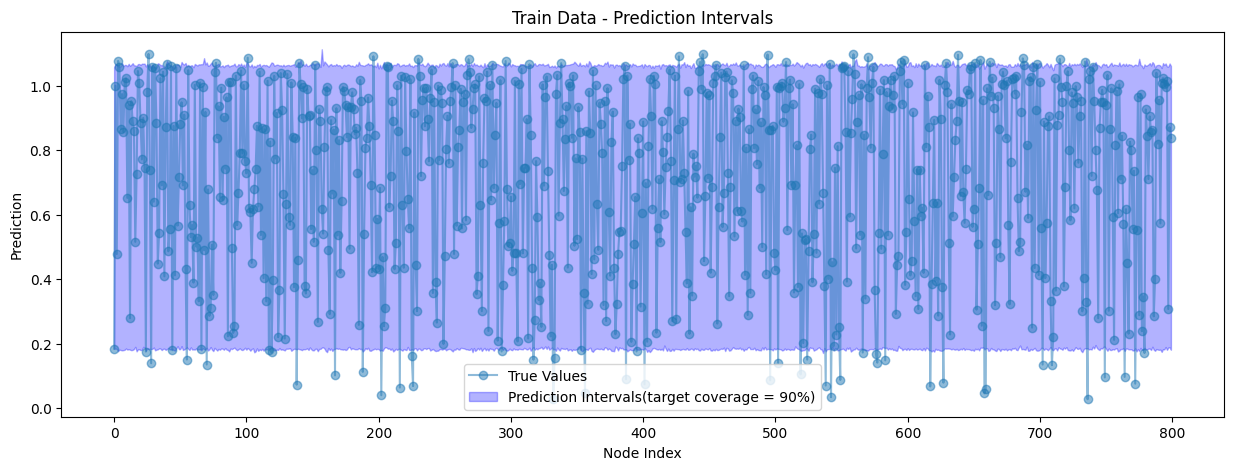

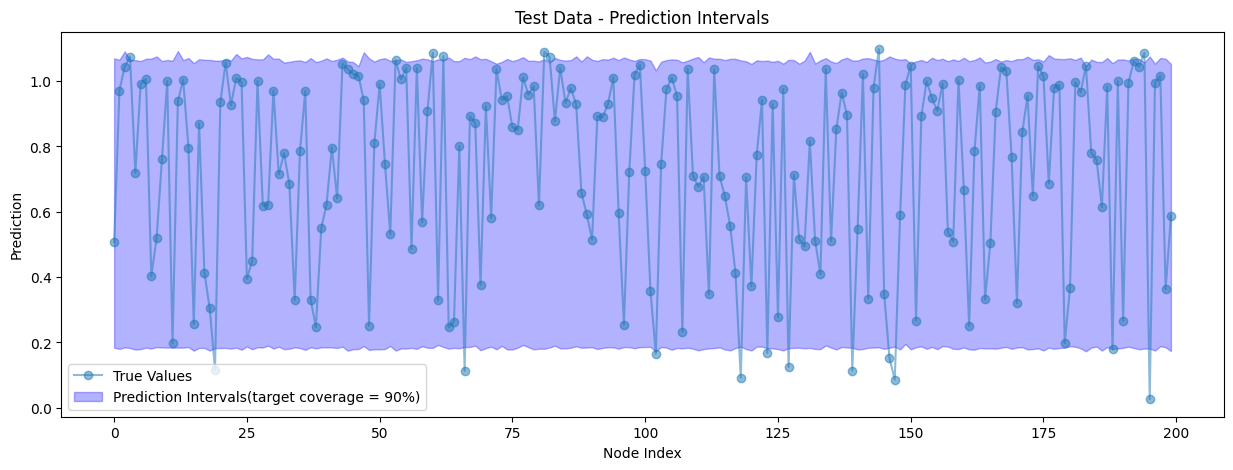

In [12]:
print('train evaluation')
advanced_evaluate_model(train_preds_bs, train_targets_bs)
print('-' * 50)
print('test evaluation')
advanced_evaluate_model(test_preds_bs, test_targets_bs)
print('-' * 50)
print('Visualization')
visualize_results(train_preds_bs, train_targets_bs, title="Train Data - Prediction Intervals")
visualize_results(test_preds_bs, test_targets_bs, title="Test Data - Prediction Intervals")

## 노이즈 그래프

gaussian experiment start..
Epoch 0: Loss = 0.7696
Epoch 50: Loss = 0.0729
Epoch 100: Loss = 0.0617
Epoch 150: Loss = 0.0603
Epoch 200: Loss = 0.0595
Epoch 250: Loss = 0.0591
Epoch 300: Loss = 0.0590
Epoch 350: Loss = 0.0589
Epoch 400: Loss = 0.0589
Epoch 450: Loss = 0.0588
Epoch 500: Loss = 0.0588
Epoch 550: Loss = 0.0588
Epoch 600: Loss = 0.0588
Epoch 650: Loss = 0.0588
Epoch 700: Loss = 0.0588
Epoch 750: Loss = 0.0588
Epoch 800: Loss = 0.0588
Epoch 850: Loss = 0.0588
Epoch 900: Loss = 0.0588
Epoch 950: Loss = 0.0588
   - Coverage Rate: 0.9000 (목표: 0.9)
   - Prediction Interval Width (PIW): 1.1182
   - Mean Absolute Error (MAE): 0.2903
   - Sharpness: 1.2504 (작을수록 좋음)
   - Interval Score (IS): 1.1193 (작을수록 좋음)
   - Pinball Loss (Lower): 0.0373, (Upper): 0.0301
   - Calibration Error: 0.0000 (0에 가까울수록 좋음)

   - Coverage Rate: 0.9001 (목표: 0.9)
   - Prediction Interval Width (PIW): 1.1181
   - Mean Absolute Error (MAE): 0.2760
   - Sharpness: 1.2502 (작을수록 좋음)
   - Interval Score (IS): 1

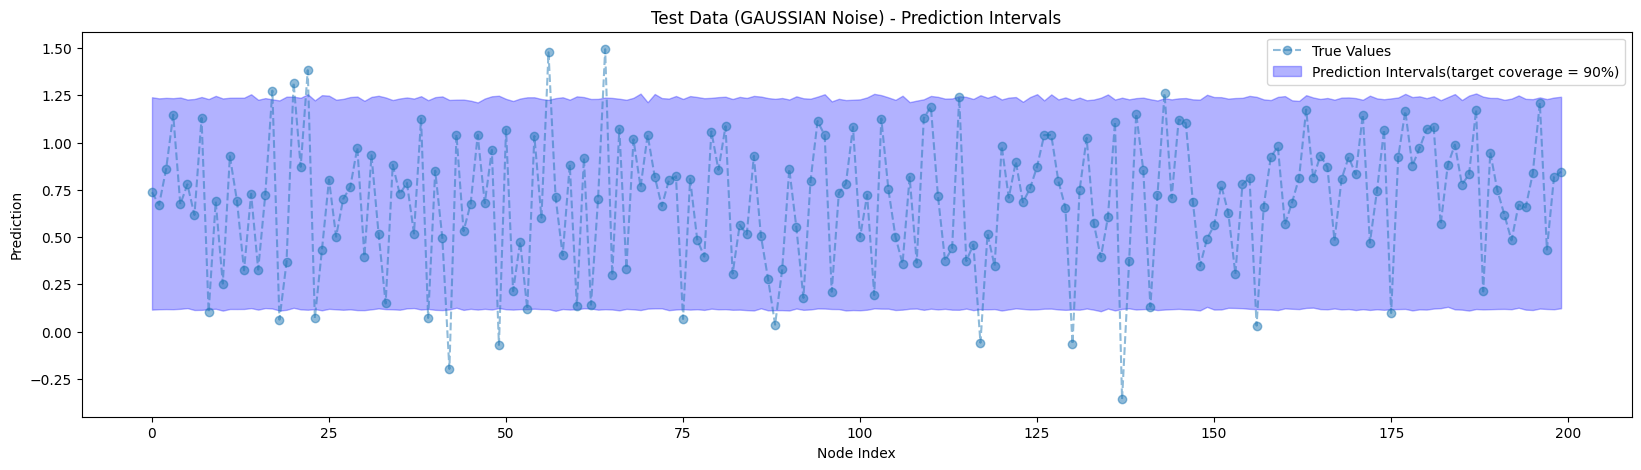

uniform experiment start..
Epoch 0: Loss = 0.7285
Epoch 50: Loss = 0.0579
Epoch 100: Loss = 0.0471
Epoch 150: Loss = 0.0455
Epoch 200: Loss = 0.0447
Epoch 250: Loss = 0.0444
Epoch 300: Loss = 0.0442
Epoch 350: Loss = 0.0441
Epoch 400: Loss = 0.0441
Epoch 450: Loss = 0.0441
Epoch 500: Loss = 0.0441
Epoch 550: Loss = 0.0440
Epoch 600: Loss = 0.0440
Epoch 650: Loss = 0.0440
Epoch 700: Loss = 0.0440
Epoch 750: Loss = 0.0440
Epoch 800: Loss = 0.0440
Epoch 850: Loss = 0.0440
Epoch 900: Loss = 0.0440
Epoch 950: Loss = 0.0440
   - Coverage Rate: 0.8999 (목표: 0.9)
   - Prediction Interval Width (PIW): 1.0108
   - Mean Absolute Error (MAE): 0.2764
   - Sharpness: 1.0218 (작을수록 좋음)
   - Interval Score (IS): 1.0115 (작을수록 좋음)
   - Pinball Loss (Lower): 0.0336, (Upper): 0.0239
   - Calibration Error: 0.0001 (0에 가까울수록 좋음)

   - Coverage Rate: 0.9155 (목표: 0.9)
   - Prediction Interval Width (PIW): 1.0108
   - Mean Absolute Error (MAE): 0.2807
   - Sharpness: 1.0219 (작을수록 좋음)
   - Interval Score (IS): 1.

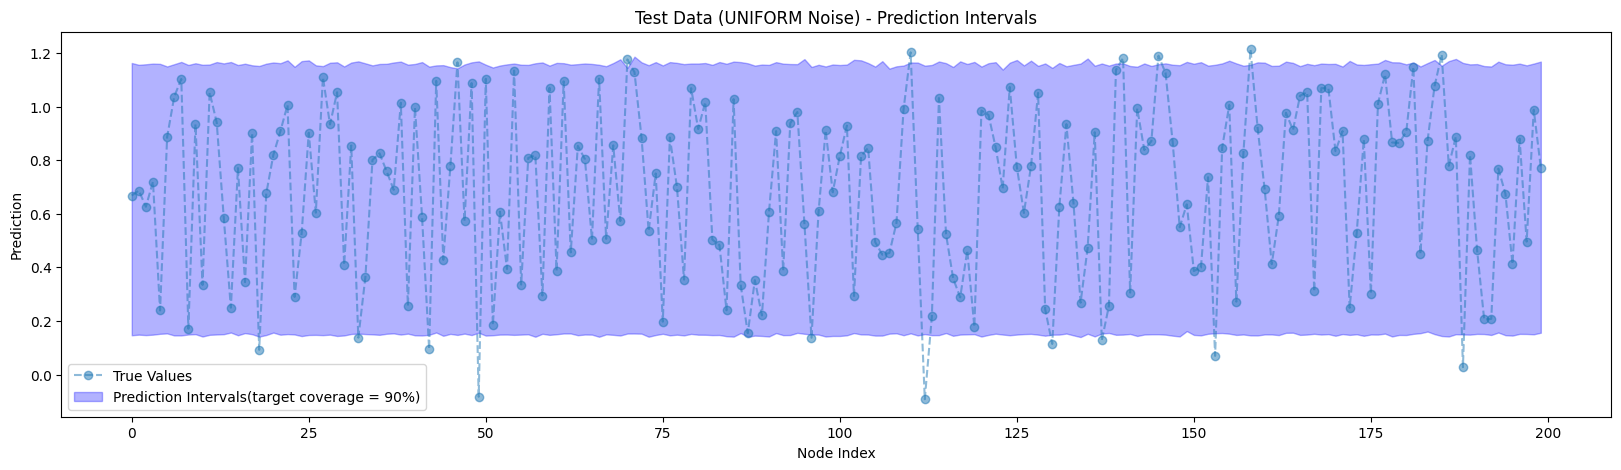

outlier experiment start..
Epoch 0: Loss = 1.6024
Epoch 50: Loss = 0.5517
Epoch 100: Loss = 0.5379
Epoch 150: Loss = 0.5354
Epoch 200: Loss = 0.5344
Epoch 250: Loss = 0.5340
Epoch 300: Loss = 0.5338
Epoch 350: Loss = 0.5337
Epoch 400: Loss = 0.5337
Epoch 450: Loss = 0.5336
Epoch 500: Loss = 0.5336
Epoch 550: Loss = 0.5336
Epoch 600: Loss = 0.5336
Epoch 650: Loss = 0.5336
Epoch 700: Loss = 0.5336
Epoch 750: Loss = 0.5335
Epoch 800: Loss = 0.5335
Epoch 850: Loss = 0.5335
Epoch 900: Loss = 0.5335
Epoch 950: Loss = 0.5335
   - Coverage Rate: 0.9000 (목표: 0.9)
   - Prediction Interval Width (PIW): 2.4321
   - Mean Absolute Error (MAE): 0.7798
   - Sharpness: 5.9153 (작을수록 좋음)
   - Interval Score (IS): 2.4391 (작을수록 좋음)
   - Pinball Loss (Lower): 0.0388, (Upper): 0.1528
   - Calibration Error: 0.0000 (0에 가까울수록 좋음)

   - Coverage Rate: 0.8933 (목표: 0.9)
   - Prediction Interval Width (PIW): 2.4323
   - Mean Absolute Error (MAE): 0.8017
   - Sharpness: 5.9160 (작을수록 좋음)
   - Interval Score (IS): 2.

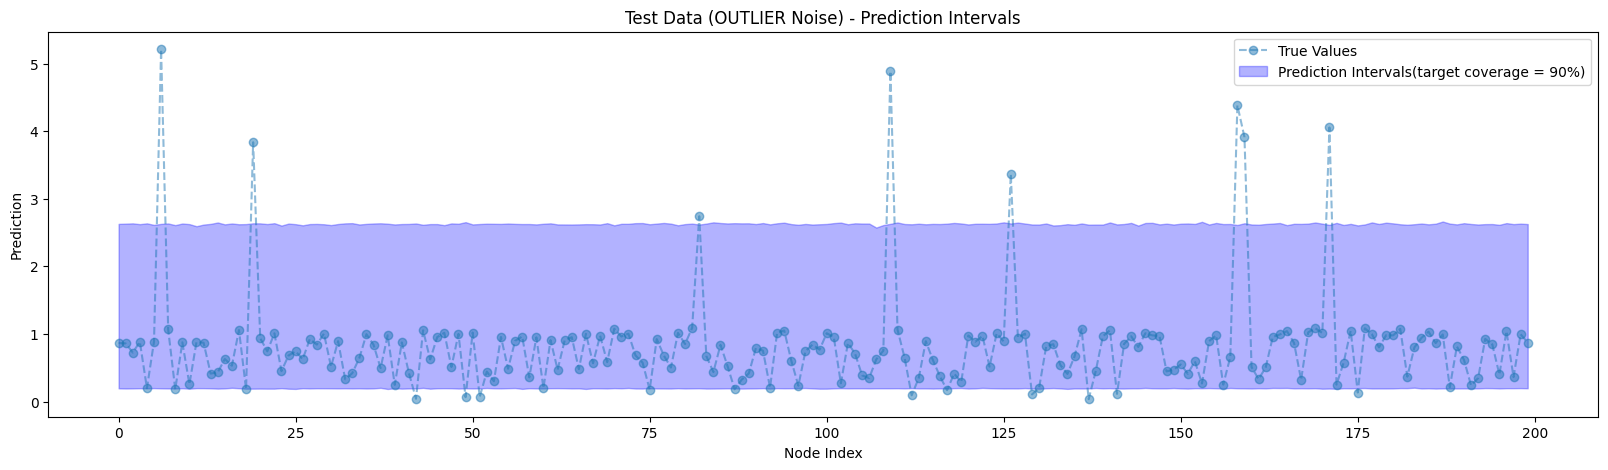

edge_noise experiment start..
Epoch 0: Loss = 0.5293
Epoch 50: Loss = 0.0402
Epoch 100: Loss = 0.0352
Epoch 150: Loss = 0.0335
Epoch 200: Loss = 0.0332
Epoch 250: Loss = 0.0331
Epoch 300: Loss = 0.0331
Epoch 350: Loss = 0.0331
Epoch 400: Loss = 0.0331
Epoch 450: Loss = 0.0330
Epoch 500: Loss = 0.0330
Epoch 550: Loss = 0.0330
Epoch 600: Loss = 0.0330
Epoch 650: Loss = 0.0330
Epoch 700: Loss = 0.0330
Epoch 750: Loss = 0.0330
Epoch 800: Loss = 0.0330
Epoch 850: Loss = 0.0330
Epoch 900: Loss = 0.0330
Epoch 950: Loss = 0.0330
   - Coverage Rate: 0.0000 (목표: 0.9)
   - Prediction Interval Width (PIW): -0.8722
   - Mean Absolute Error (MAE): 0.2695
   - Sharpness: 0.7608 (작을수록 좋음)
   - Interval Score (IS): -0.7845 (작을수록 좋음)
   - Pinball Loss (Lower): 0.3255, (Upper): 0.5079
   - Calibration Error: 0.9000 (0에 가까울수록 좋음)

   - Coverage Rate: 0.0000 (목표: 0.9)
   - Prediction Interval Width (PIW): -0.8726
   - Mean Absolute Error (MAE): 0.2739
   - Sharpness: 0.7616 (작을수록 좋음)
   - Interval Score (I

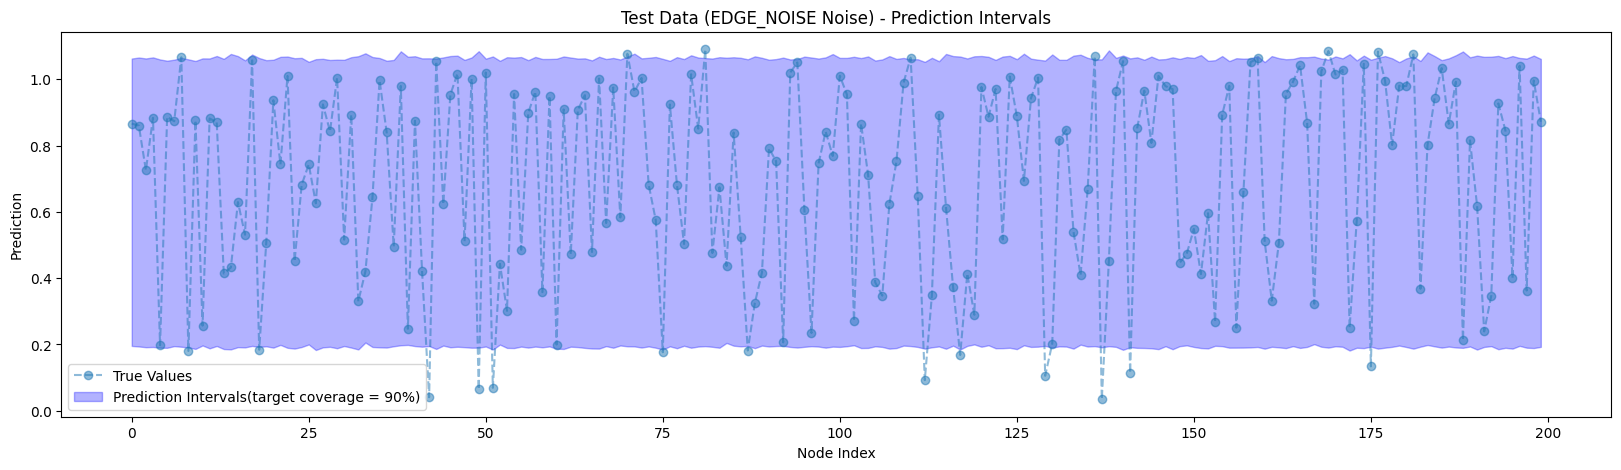

In [58]:
# 노이즈 유형
noise_types = ["gaussian", "uniform", "outlier", "edge_noise"]
experiment_results = {}

for noise in noise_types:
    print(f'{noise} experiment start..')
    noisy_graph_data = generate_noisy_graph_data(num_nodes=1000, noise_type=noise, noise_level=0.2)

    train_data, test_data = train_test_split(range(noisy_graph_data.x.shape[0]), test_size=0.2, random_state=42)

    model = train_quantile_gnn(noisy_graph_data, train_data, epochs=1000, learning_rate=0.001)

    train_preds, train_targets = test_quantile_gnn(model, noisy_graph_data, train_data)
    test_preds, test_targets = test_quantile_gnn(model, noisy_graph_data, test_data)

    train_results = advanced_evaluate_model(train_preds, train_targets)
    test_results = advanced_evaluate_model(test_preds, test_targets)
    experiment_results[noise] = {"train": train_results, "test": test_results}
    
    visualize_results(test_preds, test_targets, title=f"Test Data ({noise.upper()} Noise) - Prediction Intervals")

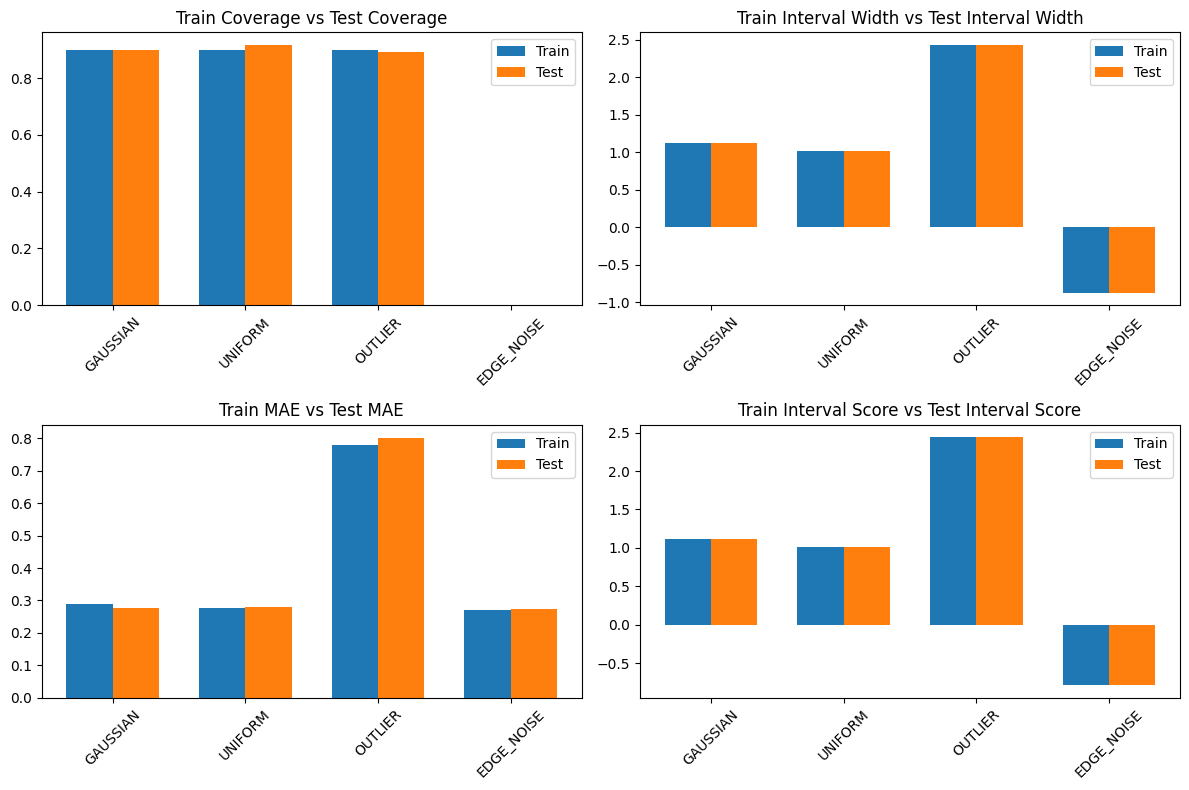

In [73]:
experiment_df = experiment_results_to_df(experiment_results)

plot_experiment_results(experiment_df)

In [ ]:
# wikipedia 데이터셋
graph_data_wiki_ch = load_graph_data('wiki',
    "dataset/wikipedia/chameleon/musae_chameleon_edges.csv",
    "dataset/wikipedia/chameleon/musae_chameleon_features.json",
    "dataset/wikipedia/chameleon/musae_chameleon_target.csv"
)

graph_data_wiki_cr = load_graph_data('wiki',
    "dataset/wikipedia/crocodile/musae_crocodile_edges.csv",
    "dataset/wikipedia/crocodile/musae_crocodile_features.json",
    "dataset/wikipedia/crocodile/musae_crocodile_target.csv"
)

graph_data_wiki_sq = load_graph_data('wiki',
    "dataset/wikipedia/squirrel/musae_squirrel_edges.csv",
    "dataset/wikipedia/squirrel/musae_squirrel_features.json",
    "dataset/wikipedia/squirrel/musae_squirrel_target.csv"
)

print('chameleon dataset:', graph_data_wiki_ch)
print('crocodile dataset:', graph_data_wiki_cr)
print('squirrel dataset:', graph_data_wiki_sq)


chameleon dataaset: Data(x=[2277, 3132], edge_index=[2, 36101], y=[2277, 1])
crocodile dataaset: Data(x=[11631, 13183], edge_index=[2, 180020], y=[11631, 1])
squirrel dataaset: Data(x=[5201, 3148], edge_index=[2, 217073], y=[5201, 1])


twitch DE dataset: Data(x=[9498, 3170], edge_index=[2, 153138], y=[9498, 1])
twitch ENGB dataset: Data(x=[7126, 3170], edge_index=[2, 35324], y=[7126, 1])
twitch ES dataset: Data(x=[4648, 3170], edge_index=[2, 59382], y=[4648, 1])
twitch FR dataset: Data(x=[6549, 3170], edge_index=[2, 112666], y=[6549, 1])
twitch PTBR dataset: Data(x=[1912, 3169], edge_index=[2, 31299], y=[1912, 1])
twitch RU dataset: Data(x=[4385, 3170], edge_index=[2, 37304], y=[4385, 1])


## County 데이터셋

In [90]:
# 미국 카운티별 데이터를 불러와 그래프를 구성
# 예측하고 하는 변수: 소득, 이주율, 출생률, 사망률, 교육 수준, 실업률, 선거 결과
# prediction: income, (migration, birth, death), education, unemployment, election
# year: 분석할 연도

In [122]:
def max_normalize(x):
    return x / np.max(np.abs(x)) if np.max(np.abs(x)) != 0 else x

def std_normalize(x):
    return (x - np.mean(x)) / np.std(x) if np.std(x) != 0 else np.zeros(len(x))

def int_normalize(x):
    return ((x - np.min(x)) / (np.max(x) - np.min(x)) * 2 - 1) if np.std(x) != 0 else np.zeros(len(x))

def simulate_ising(n, h0, J):
    G = nx.grid_2d_graph(n, n)
    l = np.linspace(-1.0, 1.0, n)
    
    s = np.random.choice([-1, 1], size=(n, n))
    # Placeholder for metropolis algorithm
    y = s.flatten()
    f = [[l[i], l[j]] for j in range(n) for i in range(n)]
    
    return G, [nx.to_scipy_sparse_matrix(G)], y, f

def parse_mean_fill(series, normalize=False):
    series = series.replace({',': ''}, regex=True)
    series = pd.to_numeric(series, errors='coerce')
    mean_val = series.mean()
    series.fillna(mean_val, inplace=True)
    
    if normalize:
        series = (series - mean_val) / series.std()
    
    return series.values

def read_county(prediction, year):
    adj = pd.read_csv("dataset/election/adjacency.txt", header=None, sep="\t", dtype=str, encoding="ISO-8859-1")
    fips2cty = {row[1]: row[0] for _, row in adj.iterrows() if pd.notna(row[1])}
    
    hh = adj.iloc[:, 1].ffill().astype(int)
    tt = adj.iloc[:, 3].astype(int)
    
    fips = sorted(set(hh).union(set(tt)))
    id2num = {id_: num for num, id_ in enumerate(fips)}
    
    G = nx.Graph()
    G.add_nodes_from(range(len(id2num)))
    G.add_edges_from([(id2num[h], id2num[t]) for h, t in zip(hh, tt)])
    
    # Load datasets
    VOT = pd.read_csv("dataset/election/election.csv")
    ICM = pd.read_csv("dataset/election/income.csv")
    POP = pd.read_csv("dataset/election/population.csv")
    EDU = pd.read_csv("dataset/election/education.csv")
    UEP = pd.read_csv("dataset/election/unemployment.csv")
    
    cty = pd.DataFrame({'FIPS': fips, 'County': [fips2cty.get(f, '') for f in fips]})
    vot = VOT[['fips_code', f'dem_{year}', f'gop_{year}']].rename(columns={'fips_code': 'FIPS'})
    icm = ICM[['FIPS', f'MedianIncome{min(max(2011, year), 2018)}']]
    pop = POP[['FIPS', f'R_NET_MIG_{min(max(2011, year), 2018)}', f'R_birth_{min(max(2011, year), 2018)}', f'R_death_{min(max(2011, year), 2018)}']]
    edu = EDU[['FIPS', f'BachelorRate{year}']]
    uep = UEP[['FIPS', f'Unemployment_rate_{min(max(2007, year), 2018)}']]
    
    dat = cty.merge(vot, on='FIPS', how='left')
    dat = dat.merge(icm, on='FIPS', how='left')
    dat = dat.merge(pop, on='FIPS', how='left')
    dat = dat.merge(edu, on='FIPS', how='left')
    dat = dat.merge(uep, on='FIPS', how='left')
    
    # Extract features and labels
    dem = parse_mean_fill(dat.iloc[:, 2])
    gop = parse_mean_fill(dat.iloc[:, 3])
    
    ff = np.zeros((len(dat), 7), dtype=np.float32)
    for i in range(6):
        ff[:, i] = parse_mean_fill(dat.iloc[:, i + 4], normalize=True)
    
    ff[:, 6] = (gop - dem) / (gop + dem)
    
    label_mapping = {
        "income": 0, "migration": 1, "birth": 2, "death": 3,
        "education": 4, "unemployment": 5, "election": 6
    }
    
    if prediction not in label_mapping:
        raise ValueError("Unexpected prediction type")
    
    pos = label_mapping[prediction]
    y = ff[:, pos]
    f = [np.concatenate((ff[i, :pos], ff[i, pos + 1:])) for i in range(len(dat))]
    
    return G, [csr_matrix(nx.adjacency_matrix(G))], y, f

def load_county_graph_data(prediction: str, year: int):
    G, A, labels, feats = read_county(prediction, year)

    mapping = {node: i for i, node in enumerate(G.nodes())}
    G = nx.relabel_nodes(G, mapping)

    pyg_data = from_networkx(G)

    edge_index = pyg_data.edge_index
    sorted_edges = torch.sort(edge_index, dim=0)[0]  # (u, v)와 (v, u)를 정렬
    unique_edges = torch.unique(sorted_edges, dim=1)  # 고유 엣지만 유지
    pyg_data.edge_index = unique_edges  # 중복 제거된 edge_index 적용

    pyg_data.x = torch.tensor(feats, dtype=torch.float)

    pyg_data.y = torch.tensor(labels, dtype=torch.float).view(-1, 1)

    return pyg_data

In [ ]:
graph_data_county_edu = load_county_graph_data('education', 2012)
graph_data_county_elec = load_county_graph_data('election', 2012)
graph_data_county_inc = load_county_graph_data('income', 2012)
graph_data_county_unemp = load_county_graph_data('unemployment', 2012)

print('county education dataset:', graph_data_county_edu)
print('county election dataset:', graph_data_county_elec)
print('county income dataset:', graph_data_county_inc)
print('county unemployment dataset:', graph_data_county_unemp)

county education dataset: Data(edge_index=[2, 12717], num_nodes=3234, x=[3234, 6], y=[3234, 1])
county election dataset: Data(edge_index=[2, 12717], num_nodes=3234, x=[3234, 6], y=[3234, 1])
county income dataset: Data(edge_index=[2, 12717], num_nodes=3234, x=[3234, 6], y=[3234, 1])
county unemployment dataset: Data(edge_index=[2, 12717], num_nodes=3234, x=[3234, 6], y=[3234, 1])


## Twitch 데이터셋

In [17]:
# twitch 데이터셋
# Twitch : 3,170
graph_data_twitch_de = load_graph_data('twitch',
    "dataset/twitch/DE/musae_DE_edges.csv",
    "dataset/twitch/DE/musae_DE_features.json",
    "dataset/twitch/DE/musae_DE_target.csv"
)

graph_data_twitch_engb = load_graph_data('twitch',
    "dataset/twitch/ENGB/musae_ENGB_edges.csv",
    "dataset/twitch/ENGB/musae_ENGB_features.json",
    "dataset/twitch/ENGB/musae_ENGB_target.csv"
)

graph_data_twitch_es = load_graph_data('twitch',
    "dataset/twitch/ES/musae_ES_edges.csv",
    "dataset/twitch/ES/musae_ES_features.json",
    "dataset/twitch/ES/musae_ES_target.csv"
)

graph_data_twitch_fr = load_graph_data('twitch',
    "dataset/twitch/FR/musae_FR_edges.csv",
    "dataset/twitch/FR/musae_FR_features.json",
    "dataset/twitch/FR/musae_FR_target.csv"
)

graph_data_twitch_ptbr = load_graph_data('twitch',
    "dataset/twitch/PTBR/musae_PTBR_edges.csv",
    "dataset/twitch/PTBR/musae_PTBR_features.json",
    "dataset/twitch/PTBR/musae_PTBR_target.csv"
)

graph_data_twitch_ru = load_graph_data('twitch',
    "dataset/twitch/RU/musae_RU_edges.csv",
    "dataset/twitch/RU/musae_RU_features.json",
    "dataset/twitch/RU/musae_RU_target.csv"
)

print('twitch DE dataset:', graph_data_twitch_de)
print('twitch ENGB dataset:', graph_data_twitch_engb)
print('twitch ES dataset:', graph_data_twitch_es)
print('twitch FR dataset:', graph_data_twitch_fr)
print('twitch PTBR dataset:', graph_data_twitch_ptbr)
print('twitch RU dataset:', graph_data_twitch_ru)

twitch DE dataset: Data(x=[9498, 3170], edge_index=[2, 153138], y=[9498, 1])
twitch ENGB dataset: Data(x=[7126, 3170], edge_index=[2, 35324], y=[7126, 1])
twitch ES dataset: Data(x=[4648, 3170], edge_index=[2, 59382], y=[4648, 1])
twitch FR dataset: Data(x=[6549, 3170], edge_index=[2, 112666], y=[6549, 1])
twitch PTBR dataset: Data(x=[1912, 3169], edge_index=[2, 31299], y=[1912, 1])
twitch RU dataset: Data(x=[4385, 3170], edge_index=[2, 37304], y=[4385, 1])


## Trans 데이터셋

In [24]:
def read_transportation_network(network_name, net_skips, net_cols, netf_cols, flow_skips, flow_cols, V_range):
    # Load data
    dat_net = pd.read_csv(f"dataset/transportation/{network_name}/{network_name}_net.tntp", 
                           skiprows=net_skips, sep='\s+', usecols=net_cols, header=None).values
    dat_netf = pd.read_csv(f"dataset/transportation/{network_name}/{network_name}_net.tntp", 
                            skiprows=net_skips, sep='\s+', usecols=netf_cols, header=None).values
    dat_flow = pd.read_csv(f"dataset/transportation/{network_name}/{network_name}_flow.tntp", 
                            skiprows=flow_skips, sep='\s+', usecols=flow_cols, header=None).values
    
    # Map node labels to indices
    lb2id = {v: i for i, v in enumerate(V_range, start=1)}
    NV = len(V_range)
    
    # Create directed graph
    g = nx.DiGraph()
    g.add_nodes_from(range(1, NV + 1))
    
    for src, dst in dat_net:
        if src in lb2id and dst in lb2id:
            g.add_edge(lb2id[src], lb2id[dst])
    
    # Edge labels
    flow_dict = {}
    for src, dst, flow in dat_flow:
        if src in lb2id and dst in lb2id:
            flow_dict[(lb2id[src], lb2id[dst])] = flow
    
    y = np.array([flow_dict.get((e[0], e[1]), 0) for e in g.edges()])
    y = (y - np.mean(y)) / np.std(y)  # Standard normalization
    
    # Edge features
    netf_dict = {}
    for i in range(len(dat_net)):
        src, dst = dat_net[i]
        if src in lb2id and dst in lb2id:
            netf_dict[(lb2id[src], lb2id[dst])] = dat_netf[i]
    
    ff = np.array([netf_dict[e] for e in g.edges()])
    mean_ff = np.mean(ff, axis=0)
    std_ff = np.std(ff, axis=0)
    std_ff[std_ff == 0] = 1  # Prevent division by zero
    netf = (ff - mean_ff) / std_ff  
    
    f = list(netf)
    
    # Line graph transformation
    G1 = nx.Graph()
    G2 = nx.Graph()
    sorted_edges = sorted(g.edges())
    tuple2id = {e: i for i, e in enumerate(sorted_edges)}
    
    for u in g.nodes:
        innbrs = list(g.predecessors(u))
        outnbrs = list(g.successors(u))
        
        for v in innbrs:
            for w in outnbrs:
                if (v, u) in tuple2id and (u, w) in tuple2id:
                    G1.add_edge(tuple2id[(v, u)], tuple2id[(u, w)])
        
        for v in innbrs:
            for w in innbrs:
                if w > v and (v, u) in tuple2id and (w, u) in tuple2id:
                    G2.add_edge(tuple2id[(v, u)], tuple2id[(w, u)])
        
        for v in outnbrs:
            for w in outnbrs:
                if w > v and (u, v) in tuple2id and (u, w) in tuple2id:
                    G2.add_edge(tuple2id[(u, v)], tuple2id[(u, w)])
                    
    size = max(len(G1.nodes), len(G2.nodes))
    A1 = np.zeros((size, size))
    A2 = np.zeros((size, size))
    
    A1[:nx.number_of_nodes(G1), :nx.number_of_nodes(G1)] = nx.adjacency_matrix(G1).todense()
    A2[:nx.number_of_nodes(G2), :nx.number_of_nodes(G2)] = nx.adjacency_matrix(G2).todense()
    
    A = A1 + A2
    
    return nx.Graph(A), A, y, f

def load_trans_graph_data(city: str):
    if city == 'Anaheim':
        G, A, labels, feats = read_transportation_network(city, 8, [0, 1], [2, 3, 4, 7], 6, [0, 1, 3], range(1, 417))
    elif city == 'ChicagoSketch':
        G, A, labels, feats = read_transportation_network(city, 7, [0, 1], [2, 3, 4, 7], 1, [0, 1, 2], range(388, 934))

    mapping = {node: i for i, node in enumerate(G.nodes())}
    G = nx.relabel_nodes(G, mapping)

    pyg_data = from_networkx(G)

    edge_index = pyg_data.edge_index
    sorted_edges = torch.sort(edge_index, dim=0)[0]  # (u, v)와 (v, u)를 정렬
    unique_edges = torch.unique(sorted_edges, dim=1)  # 고유 엣지만 유지
    pyg_data.edge_index = unique_edges  # 중복 제거된 edge_index 적용

    pyg_data.x = torch.tensor(feats, dtype=torch.float)

    pyg_data.y = torch.tensor(labels, dtype=torch.float).view(-1, 1)

    return pyg_data

In [25]:
graph_data_trans_ana = load_trans_graph_data('Anaheim')
graph_data_trans_chica = load_trans_graph_data('ChicagoSketch')

print('transportation Anaheim dataset:', graph_data_trans_ana)
print('transportation Chicago dataset:', graph_data_trans_chica)

transportation Anaheim dataset: Data(edge_index=[2, 3638], weight=[7276], num_nodes=914, x=[914, 4], y=[914, 1])
transportation Chicago dataset: Data(edge_index=[2, 14961], weight=[29922], num_nodes=2176, x=[2176, 4], y=[2176, 1])


In [149]:
def normalize_graph_data(graph_data, normalize_y=True, scaler_type="standard"):
    if scaler_type == "standard":
        x_scaler = StandardScaler()  # 평균 0, 표준편차 1로 변환
        y_scaler = StandardScaler() if normalize_y else None  # y도 정규화
    else:
        x_scaler = MinMaxScaler(feature_range=(0, 1))  # 0~1 범위 변환
        y_scaler = MinMaxScaler(feature_range=(0, 1)) if normalize_y else None
    
    x_numpy = graph_data.x.numpy()
    x_scaled = x_scaler.fit_transform(x_numpy)
    graph_data.x = torch.tensor(x_scaled, dtype=torch.float32)

    if normalize_y:
        y_numpy = graph_data.y.numpy().reshape(-1, 1)  # y를 2D로 변환
        y_scaled = y_scaler.fit_transform(y_numpy)
        graph_data.y = torch.tensor(y_scaled, dtype=torch.float32)
    
    return graph_data, x_scaler, y_scaler

graph_data, x_scaler, y_scaler = normalize_graph_data(graph_data, normalize_y=True, scaler_type="min-max")
train_data, test_data = train_test_split(range(graph_data.x.shape[0]), test_size=0.2, random_state=42)
model = train_quantile_gnn(graph_data, train_data, epochs=1000, learning_rate=0.001)

Epoch 0: Loss = 0.0032
Epoch 50: Loss = 0.0022
Epoch 100: Loss = 0.0022
Epoch 150: Loss = 0.0022
Epoch 200: Loss = 0.0022
Epoch 250: Loss = 0.0022
Epoch 300: Loss = 0.0022
Epoch 350: Loss = 0.0022
Epoch 400: Loss = 0.0022
Epoch 450: Loss = 0.0022
Epoch 500: Loss = 0.0022
Epoch 550: Loss = 0.0022
Epoch 600: Loss = 0.0022
Epoch 650: Loss = 0.0022
Epoch 700: Loss = 0.0022
Epoch 750: Loss = 0.0022
Epoch 800: Loss = 0.0022
Epoch 850: Loss = 0.0022
Epoch 900: Loss = 0.0022
Epoch 950: Loss = 0.0022


In [150]:
train_preds, train_targets = test_quantile_gnn(model, graph_data, train_data)
test_preds, test_targets = test_quantile_gnn(model, graph_data, test_data)

In [153]:
print('train evaluation')
advanced_evaluate_model(train_preds, train_targets)
print('-' * 50)
print('test evaluation')
advanced_evaluate_model(test_preds, test_targets)

train evaluation
   - Coverage Rate: 0.0000 (목표: 0.9)
   - Prediction Interval Width (PIW): -0.0922
   - Mean Absolute Error (MAE): 0.0441
   - Sharpness: 0.0085 (작을수록 좋음)
   - Interval Score (IS): -0.0826 (작을수록 좋음)
   - Pinball Loss (Lower): 0.0774, (Upper): 0.0144
   - Calibration Error: 0.9000 (0에 가까울수록 좋음)

--------------------------------------------------
test evaluation
   - Coverage Rate: 0.0000 (목표: 0.9)
   - Prediction Interval Width (PIW): -0.0923
   - Mean Absolute Error (MAE): 0.0443
   - Sharpness: 0.0085 (작을수록 좋음)
   - Interval Score (IS): -0.0827 (작을수록 좋음)
   - Pinball Loss (Lower): 0.0781, (Upper): 0.0137
   - Calibration Error: 0.9000 (0에 가까울수록 좋음)



{'coverage': np.float64(0.0),
 'interval_width': np.float32(-0.092346534),
 'mae': np.float32(0.044287816),
 'sharpness': np.float32(0.008529384),
 'interval_score': np.float32(-0.08270612),
 'pinball_loss_lower': np.float32(0.07809361),
 'pinball_loss_upper': np.float32(0.013693234),
 'calibration_error': np.float64(0.9)}

In [154]:
test_preds[(test_preds[:, 0] - test_preds[:, 1]) < 0]

array([], shape=(0, 2), dtype=float32)

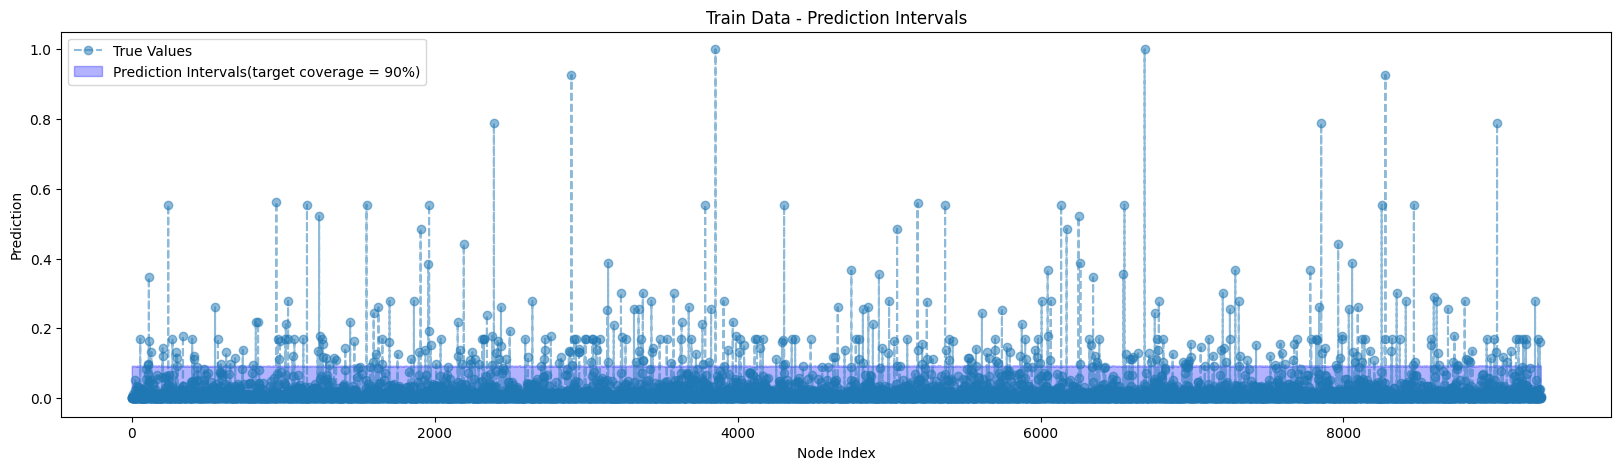

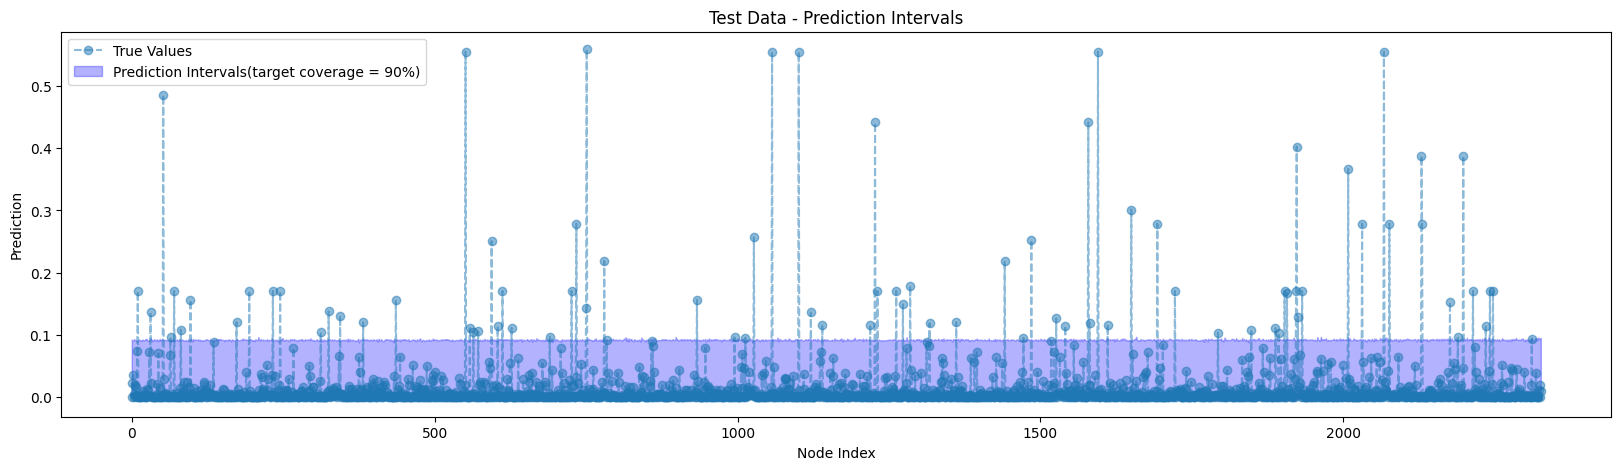

In [155]:
visualize_results(train_preds, train_targets, title="Train Data - Prediction Intervals")
visualize_results(test_preds, test_targets, title="Test Data - Prediction Intervals")